user mrmanny34 asked on discord to stack and align columns.

In [1]:
import cv2
from matplotlib import pyplot as plt

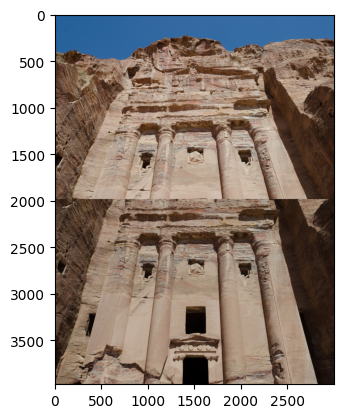

In [20]:
top     = cv2.cvtColor(cv2.imread(r'../media/Petra0.jpg', 1), cv2.COLOR_BGR2RGB)
bottom  = cv2.cvtColor(cv2.imread(r'../media/Petra1.jpg', 1), cv2.COLOR_BGR2RGB)
og_width = top.shape[1]
og_stack = cv2.vconcat((top, bottom))
plt.imshow(og_stack)

(1987, 4500, 3)
3000 4500 1500
(1987, 3000, 3)


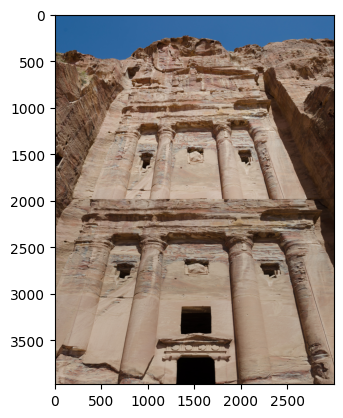

In [7]:
btm_resize = cv2.resize(bottom, None, fy = 1.0, fx = 1.5);print(btm_resize.shape)
new_width = btm_resize.shape[1]

extra_wdith = new_width - og_width
print(og_width, new_width, extra_wdith)
btm2_crop = btm_resize[:,extra_wdith//2:-extra_wdith//2, :]
print(btm2_crop.shape)
stack2 = cv2.vconcat((top, btm2_crop))
plt.imshow(stack2)

Using homography. from https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/

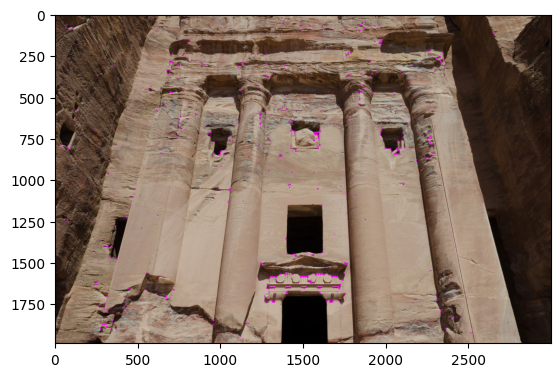

In [8]:
import cv2
import numpy as np
img1 = cv2.cvtColor(cv2.imread(r'../media/Petra0.jpg', 1), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(r'../media/Petra1.jpg', 1), cv2.COLOR_BGR2RGB)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
plt.imshow(cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255)))
plt.imshow(cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255)))

(-0.5, 5999.5, 1986.5, -0.5)

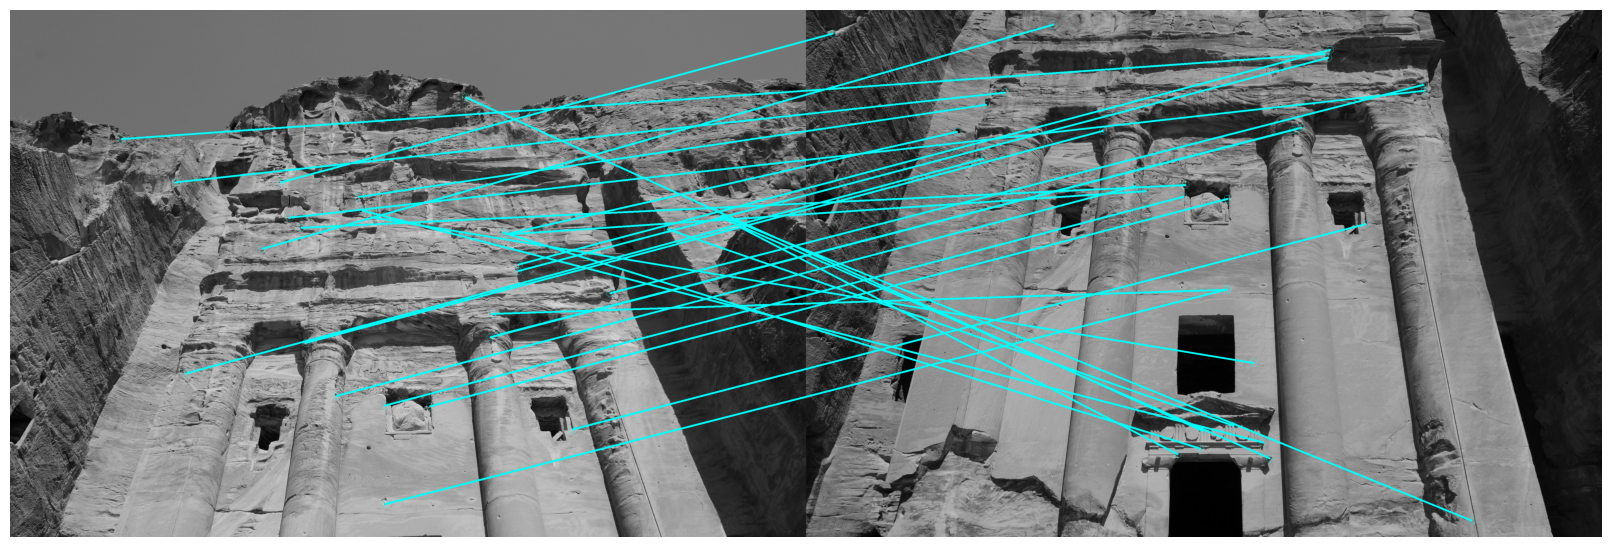

In [9]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2,k=2)
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  # Go over all of the matching points and extract them
  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv2.circle(output_img, (int(x1),int(y1)), 14, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 14, (0, 255, 255), 1)

    # Connect the same keypoints
    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 6)
    
  return output_img

all_matches = []
for m, n in matches:
  all_matches.append(m)

img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
fig, ax = plt.subplots(1, 1, figsize=(16, 9), layout='constrained')
ax.imshow(img3)
ax.axis('off')

(-0.5, 2999.5, 1986.5, -0.5)

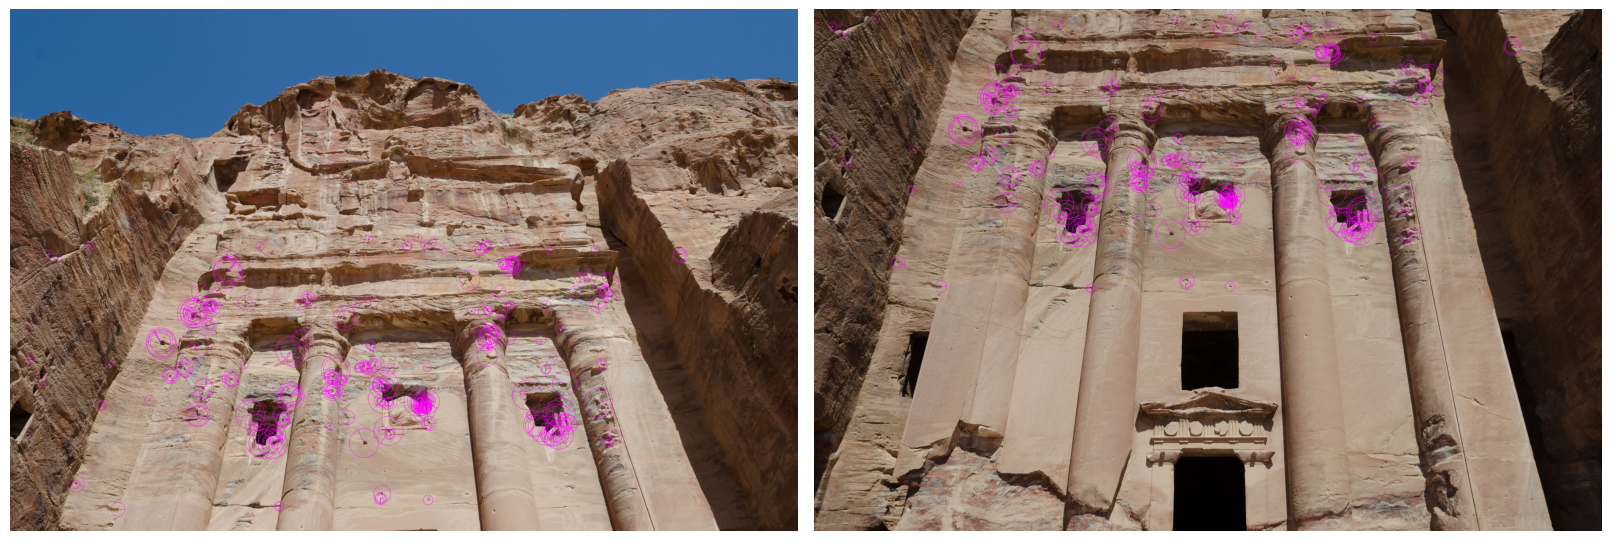

In [10]:
# Finding the best matches
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

a = cv2.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
b = cv2.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig, ax = plt.subplots(1, 2, figsize=(16, 9), layout='constrained')
ax[0].imshow(a)
ax[1].imshow(b)
ax[0].axis('off')
ax[1].axis('off')

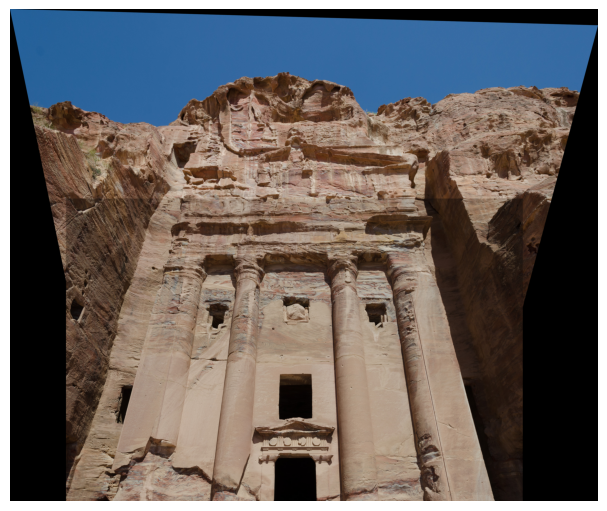

In [11]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5), layout='constrained')
    ax.imshow(result)
    ax.axis('off')

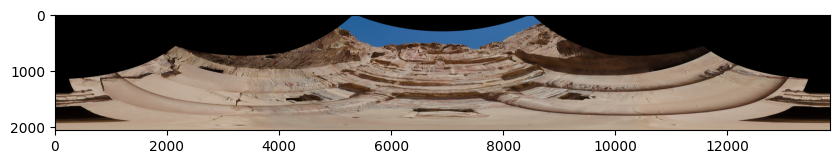

In [24]:
import cv2
#stitcher = cv2.Stitcher_create()##cv2.createStitcher(False)
stitcher = cv2.Stitcher.create()
#stitcher.setPanoConfidenceThresh(0.0)

status, result = stitcher.stitch((top,bottom))
fig = plt.figure(figsize=(10,10))
plt.imshow(result)
#cv2.imwrite("D:/result.jpg", result[1])